## **Import Packages**

In [ ]:
import json 
import torch
import config 
import tensorflow as tf
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from tabulate import tabulate 
from models.htsat import HTSAT_Swin_Transformer
from tensorflow.keras.models import load_model

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report, 
    confusion_matrix
)

In [1]:
htsat_log_file = "HTSAT_MODEL/checkpoint_20032025/events.out.tfevents.1742434082.6028f44b4ea8.52.0"
nn_training_result = "training_results.json"
device = "cuda" if torch.cuda.is_available() else "cpu"

NameError: name 'torch' is not defined

## **Load Training Results**

In [ ]:
last_loss_epoch = None
last_acc = None
last_step = None

# Read data from the log file
for event in tf.compat.v1.train.summary_iterator(htsat_log_file):
    for value in event.summary.value:
        if value.HasField("simple_value"):
            if value.tag == "loss_epoch":
                last_loss_epoch = value.simple_value
                last_step = event.step  # Track the last epoch number
            elif value.tag == "acc":
                last_acc = value.simple_value

htsat_res_dict = {
  'Model': 'HTS-AT',
  'Train Accuracy': None,
  'Train Loss': None,
  'Test Accuracy': last_acc,
  'Test Loss': last_loss_epoch
}

# ✅ Display results
if last_loss_epoch is not None and last_acc is not None:
    print(f"Final Epoch: {last_step}")
    print(f"Final Loss (loss_epoch): {last_loss_epoch}")
    print(f"Final Test Accuracy (acc): {last_acc}")
else:
    print("No loss_epoch or acc found in the log file.")

Final Epoch: 39999
Final Loss (loss_epoch): 1.4744855165481567
Final Test Accuracy (acc): 0.5809375047683716


In [ ]:
# load nn models training result 
with open(nn_training_result) as f:
    nn_results = json.load(f)
nn_results.append(htsat_res_dict)

In [ ]:
nn_results

[{'Model': 'CNN',
  'Train Accuracy': 0.9920312762260437,
  'Train Loss': 0.027370555326342583,
  'Test Accuracy': 0.9981250166893005,
  'Test Loss': 0.004840333014726639},
 {'Model': 'LSTM',
  'Train Accuracy': 0.9661718606948853,
  'Train Loss': 0.10659302026033401,
  'Test Accuracy': 0.9981250166893005,
  'Test Loss': 0.005775578785687685},
 {'Model': 'CNN_LSTM',
  'Train Accuracy': 0.9646093845367432,
  'Train Loss': 0.11917366832494736,
  'Test Accuracy': 0.9946874976158142,
  'Test Loss': 0.015968933701515198},
 {'Model': 'BiLSTM',
  'Train Accuracy': 0.8728906512260437,
  'Train Loss': 0.47085848450660706,
  'Test Accuracy': 0.6331250071525574,
  'Test Loss': 2.458519220352173},
 {'Model': 'HTS-AT',
  'Train Accuracy': None,
  'Train Loss': None,
  'Test Accuracy': 0.5809375047683716,
  'Test Loss': 1.4744855165481567}]

## **Visualize Result**

C:\Users\fury14\AppData\Local\Temp\ipykernel_14628\3626886329.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Test Accuracy", y="Model", data=df_results, palette="coolwarm")


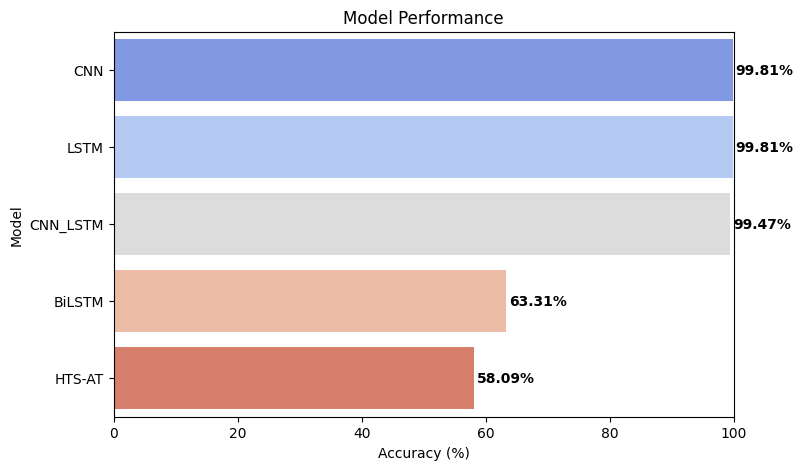

In [ ]:

# Convert results to DataFrame and sort by Test Accuracy
df_results = pd.DataFrame(nn_results).sort_values(by="Test Accuracy", ascending=False)

df_results["Test Accuracy"] *= 100

# Style DataFrame (Optional)
df_results_styled = df_results.style.background_gradient(cmap="coolwarm")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Test Accuracy", y="Model", data=df_results, palette="coolwarm")

# add value on bars
for index, value in enumerate(df_results["Test Accuracy"]):
    plt.text(value + 0.5, index, f"{value:.2f}%", va="center", fontsize=10, fontweight="bold")

# labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.title("Model Performance")
plt.xlim(0, 100)  # Ensure x-axis covers full range

# show plot
plt.show()

## **Test on ESC-50**

### 1. Load Test Dataset

In [ ]:
# load test dataset 
df_dataset = pd.read_csv("dataset.csv")
df_test = df_dataset[df_dataset["fold"] == 1]

features = [
    'zero_crossing_rate', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
    'beat_per_minute', 'rolloff', 'spectral_contrast', 'tonnetz', 'spectral_flatness',
    'mel_spectrogram', 'chroma_cens'
] + [f'mfcc_{i}' for i in range(64)]

X_test = df_test[features]
y_test = df_test["target"]

C:\Users\fury14\AppData\Local\Temp\ipykernel_14628\4188092832.py:2: DtypeWarning: Columns (0,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dataset = pd.read_csv("dataset.csv")


In [ ]:
print(X_test.shape)
print(y_test.shape)

(3200, 76)
(3200,)


### 2. Load Trained Models 

In [ ]:
cnn_model_path = "trained_models/CNN.h5"
lstm_model_path = "trained_models/LSTM.h5"
bilstm_model_path = "trained_models/BiLSTM.h5"
cnn_lstm_model_path = "trained_models/CNN_LSTM.h5"
htsat_model_path = "HTSAT_MODEL/checkpoint_20032025/checkpoints/last.ckpt"

In [ ]:
cnn_model = load_model(cnn_model_path)
lstm_model = load_model(lstm_model_path)
bilstm_model = load_model(bilstm_model_path)
cnn_lstm_model = load_model(cnn_lstm_model_path) 

In [ ]:
htsat_model = HTSAT_Swin_Transformer(
    spec_size=config.htsat_spec_size,
    patch_size=config.htsat_patch_size,
    in_chans=1,
    num_classes=config.classes_num,
    window_size=config.htsat_window_size,
    config=config,
    depths=config.htsat_depth,
    embed_dim=config.htsat_dim,
    patch_stride=config.htsat_stride,
    num_heads=config.htsat_num_head,
)

ckpt = torch.load(htsat_model_path, map_location="cpu")
temp_ckpt = {key[10:]: ckpt["state_dict"][key] for key in ckpt["state_dict"]}
htsat_model.load_state_dict(temp_ckpt)
htsat_model.to(device)
htsat_model.eval()

c:\Users\fury14\miniconda3\envs\audio\Lib\site-packages\torchlibrosa\stft.py:686: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,


HTSAT_Swin_Transformer(
  (spectrogram_extractor): Spectrogram(
    (stft): STFT(
      (conv_real): Conv1d(1, 33, kernel_size=(64,), stride=(320,), bias=False)
      (conv_imag): Conv1d(1, 33, kernel_size=(64,), stride=(320,), bias=False)
    )
  )
  (logmel_extractor): LogmelFilterBank()
  (spec_augmenter): SpecAugmentation(
    (time_dropper): DropStripes()
    (freq_dropper): DropStripes()
  )
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(64, 64), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(64, 64), num_heads=4, window_size=8, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, el

In [ ]:
total_params = sum(p.numel() for p in htsat_model.parameters())
trainable_params = sum(p.numel() for p in htsat_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 27,773,824
Trainable parameters: 27,767,488


## **Predict**

In [ ]:
final_results = []

#### **1. CNN-Model**

In [ ]:
# CNN model performance
y_pred = cnn_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, average="macro")
recall = recall_score(y_pred, y_test, average="macro")
f1score = f1_score(y_pred, y_test, average= "macro")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_score: {f1score}")

print("\033[1mClassification Report:\033[0m")
print(classification_report(y_test, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.998125
Precision: 0.9981858766233767
Recall: 0.9981274903026973
F1_score: 0.9981263318058575
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        64
           1       1.00      1.00      1.00        58
           2       0.98      1.00      0.99        60
           3       1.00      1.00      1.00        70
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        62
           7       1.00      0.98      0.99        56
           8       1.00      1.00      1.00        69
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        71
          12       1.00      1.00      1.00        67
          13       1.00      1.00      1.00        66
          14       1

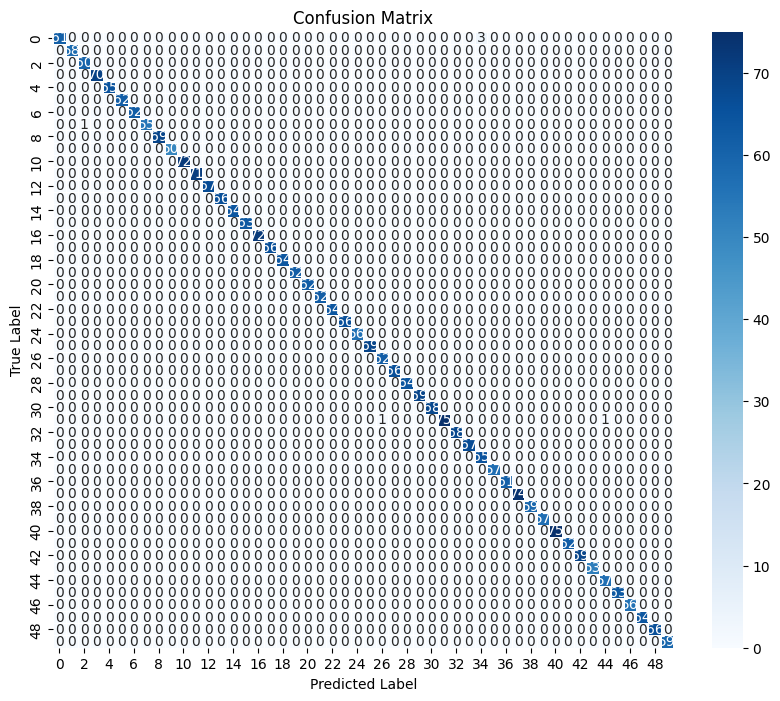

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
CNN_result = {
    "CNN": {
        "acc": accuracy, 
        "pre": precision, 
        "recall": recall, 
        "f1_score": f1score
    }
}
final_results.append(CNN_result)

#### **2. LSTM Model**

In [ ]:
# LSTM model performance
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, average="macro")
recall = recall_score(y_pred, y_test, average="macro")
f1score = f1_score(y_pred, y_test, average= "macro")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_score: {f1score}")

print("\033[1mClassification Report:\033[0m")
print(classification_report(y_test, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Accuracy: 0.998125
Precision: 0.998159476473874
Recall: 0.9981214406959217
F1_score: 0.9981286756909405
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        60
           3       1.00      0.99      0.99        70
           4       1.00      1.00      1.00        65
           5       0.98      1.00      0.99        62
           6       1.00      1.00      1.00        62
           7       1.00      1.00      1.00        56
           8       1.00      1.00      1.00        69
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        71
          12       1.00      1.00      1.00        67
          13       1.00      1.00      1.00        66
          14       1

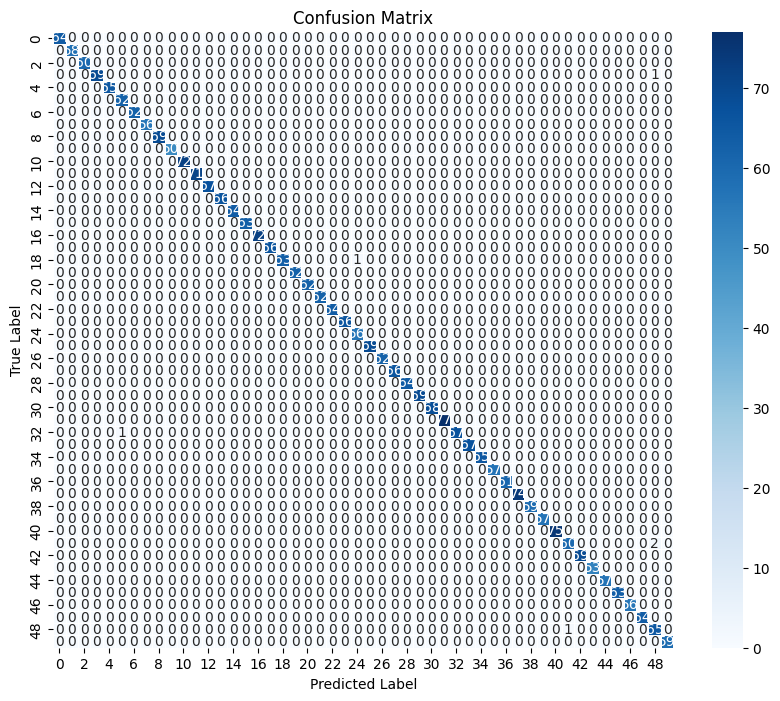

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
LSTM_result = {
    "LSTM": {
        "acc": accuracy, 
        "pre": precision, 
        "recall": recall, 
        "f1_score": f1score
    }
}
final_results.append(LSTM_result)

### **3.CNN-LSTM**

In [ ]:
# LSTM model performance
y_pred = cnn_lstm_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, average="macro")
recall = recall_score(y_pred, y_test, average="macro")
f1score = f1_score(y_pred, y_test, average= "macro")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_score: {f1score}")

print("\033[1mClassification Report:\033[0m")
print(classification_report(y_test, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.9946875
Precision: 0.9948524529865301
Recall: 0.9948662404892888
F1_score: 0.9947855796407192
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       0.97      1.00      0.98        58
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        70
           4       0.97      1.00      0.98        65
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        62
           7       1.00      1.00      1.00        56
           8       1.00      1.00      1.00        69
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00        72
          11       1.00      0.97      0.99        71
          12       0.99      1.00      0.99        67
          13       1.00      1.00      1.00        66
          14      

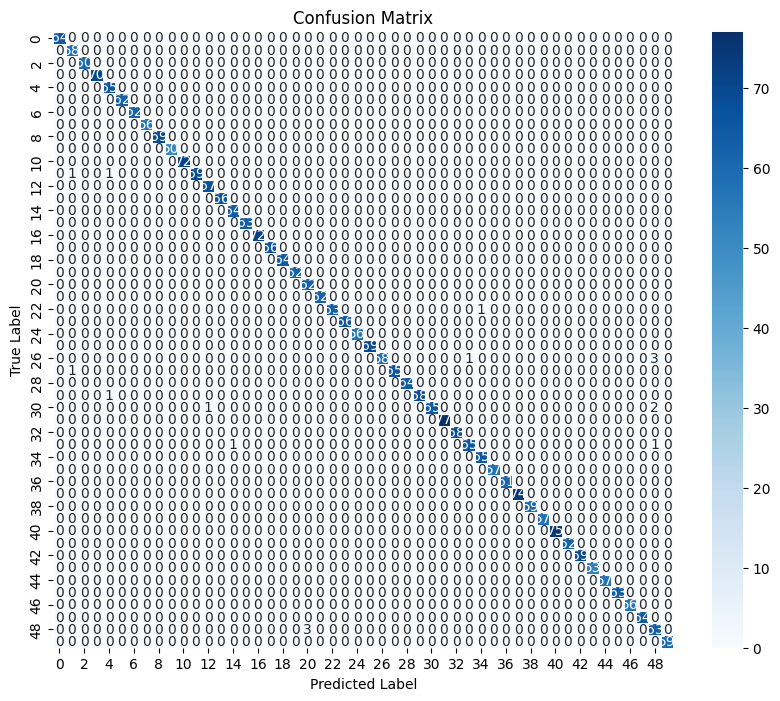

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
CNN_LSTM_result = {
    "CNN_LSTM": {
        "acc": accuracy, 
        "pre": precision, 
        "recall": recall, 
        "f1_score": f1score
    }
}
final_results.append(CNN_LSTM_result)

### **4. Bi-LSTM**

In [ ]:
# Bi-LSTM model performance
y_pred = bilstm_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, average="macro")
recall = recall_score(y_pred, y_test, average="macro")
f1score = f1_score(y_pred, y_test, average= "macro")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_score: {f1score}")

print("\033[1mClassification Report:\033[0m")
print(classification_report(y_test, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Accuracy: 0.633125
Precision: 0.6344279733424915
Recall: 0.7189029111314469
F1_score: 0.6344396766276319
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.34      0.41        64
           1       0.67      0.71      0.69        58
           2       0.88      0.63      0.74        60
           3       0.86      0.36      0.51        70
           4       0.61      0.54      0.57        65
           5       0.70      0.71      0.70        62
           6       0.59      0.61      0.60        62
           7       0.86      0.75      0.80        56
           8       0.93      0.54      0.68        69
           9       0.81      0.84      0.82        50
          10       1.00      0.76      0.87        72
          11       0.51      0.79      0.62        71
          12       0.75      0.22      0.34        67
          13       0.70      0.73      0.71        66
          14       

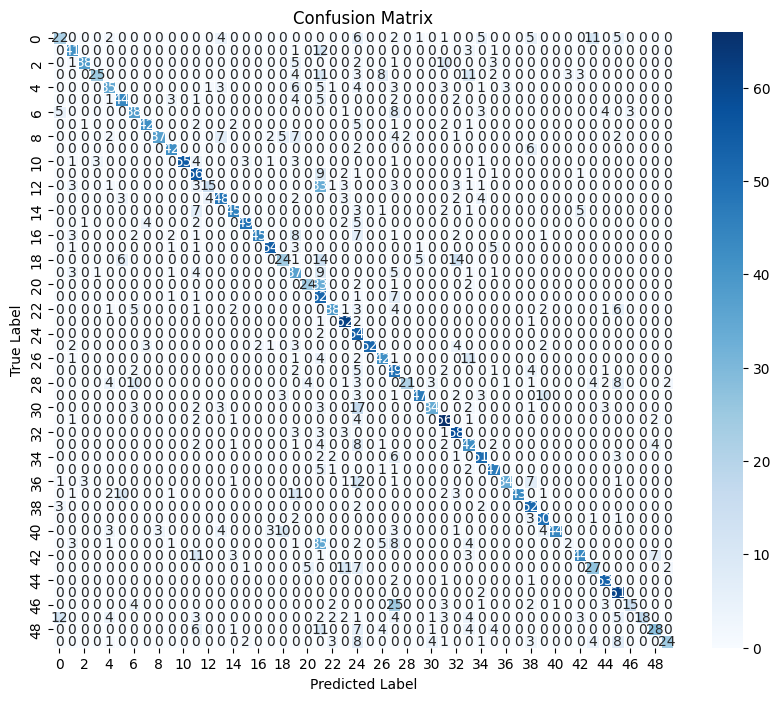

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
BiLSTM_result = {
    "BiLSTM": {
        "acc": accuracy, 
        "pre": precision, 
        "recall": recall, 
        "f1_score": f1score
    }
}
final_results.append(BiLSTM_result)

### **5. HTS-AT Model**

In [ ]:
# predict 
y_pred = []

with torch.no_grad():
    for x in X_test.values:
        x = torch.from_numpy(np.array(x)).float().to(device).unsqueeze(0)
        output_dict = htsat_model(x)
        pred = output_dict["clipwise_output"]
        pred_numpy = pred.detach().cpu().numpy()

        if pred_numpy.ndim == 2: 
            pred_label = np.argmax(pred_numpy, axis=1)[0]
        else: 
            pred_label = np.argmax(pred_numpy)

        y_pred.append(pred_label)

y_pred = np.array(y_pred)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_score: {f1}")

print("\033[1mClassification Report:\033[0m")
print(classification_report(y_test, y_pred))

Accuracy: 0.5809375
Precision: 0.6053879991046401
Recall: 0.5779033011320124
F1_score: 0.5763306537817523
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        64
           1       0.47      0.38      0.42        58
           2       0.59      0.45      0.51        60
           3       0.60      0.41      0.49        70
           4       0.79      0.35      0.49        65
           5       0.85      0.66      0.75        62
           6       0.50      0.52      0.51        62
           7       0.31      0.55      0.40        56
           8       0.88      0.88      0.88        69
           9       0.38      0.56      0.45        50
          10       1.00      0.57      0.73        72
          11       0.34      0.55      0.42        71
          12       0.47      0.57      0.51        67
          13       0.71      0.74      0.73        66
          14       0.50      0.52      0.51        64
      

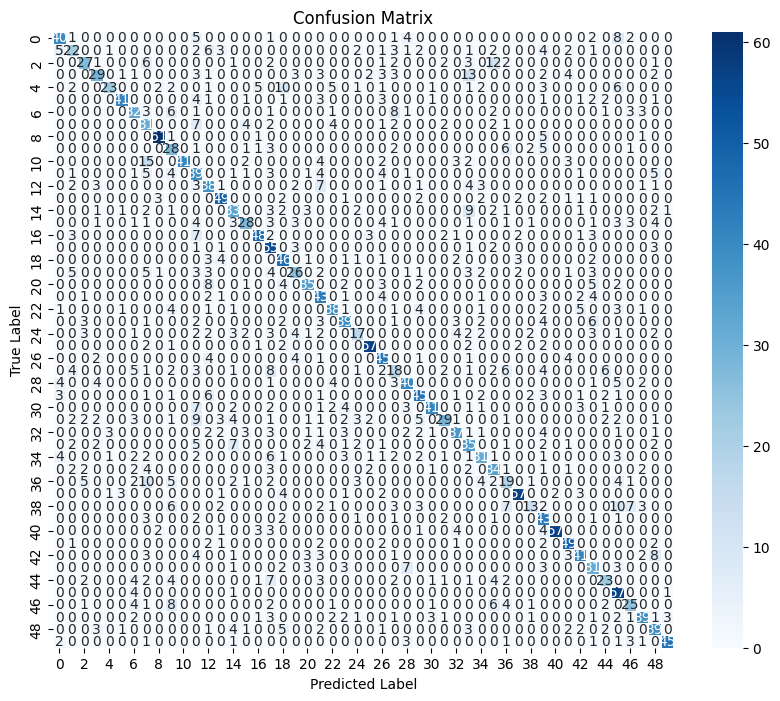

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# draw heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
HTSAT_result = {
    "HTSAT": {
        "acc": accuracy, 
        "pre": precision, 
        "recall": recall, 
        "f1_score": f1
    }
}
final_results.append(HTSAT_result)

## **Summary Result**

In [ ]:
final_results

[{'CNN': {'acc': 0.998125,
   'pre': 0.9981858766233767,
   'recall': 0.9981274903026973,
   'f1_score': 0.9981263318058575}},
 {'LSTM': {'acc': 0.998125,
   'pre': 0.998159476473874,
   'recall': 0.9981214406959217,
   'f1_score': 0.9981286756909405}},
 {'CNN_LSTM': {'acc': 0.9946875,
   'pre': 0.9948524529865301,
   'recall': 0.9948662404892888,
   'f1_score': 0.9947855796407192}},
 {'BiLSTM': {'acc': 0.633125,
   'pre': 0.6344279733424915,
   'recall': 0.7189029111314469,
   'f1_score': 0.6344396766276319}},
 {'HTSAT': {'acc': 0.5809375,
   'pre': 0.6053879991046401,
   'recall': 0.5779033011320124,
   'f1_score': 0.5763306537817523}}]

In [ ]:
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]
rows = []

for entry in final_results:
    for model, metrics in entry.items():
        rows.append([
            model,
            round(metrics["acc"], 4),
            round(metrics["pre"], 4),
            round(metrics["recall"], 4),
            round(metrics["f1_score"], 4)
        ])

print(tabulate(rows, headers=headers, tablefmt="grid"))

+----------+------------+-------------+----------+------------+
| Model    |   Accuracy |   Precision |   Recall |   F1-score |
+==========+============+=============+==========+============+
| CNN      |     0.9981 |      0.9982 |   0.9981 |     0.9981 |
+----------+------------+-------------+----------+------------+
| LSTM     |     0.9981 |      0.9982 |   0.9981 |     0.9981 |
+----------+------------+-------------+----------+------------+
| CNN_LSTM |     0.9947 |      0.9949 |   0.9949 |     0.9948 |
+----------+------------+-------------+----------+------------+
| BiLSTM   |     0.6331 |      0.6344 |   0.7189 |     0.6344 |
+----------+------------+-------------+----------+------------+
| HTSAT    |     0.5809 |      0.6054 |   0.5779 |     0.5763 |
+----------+------------+-------------+----------+------------+


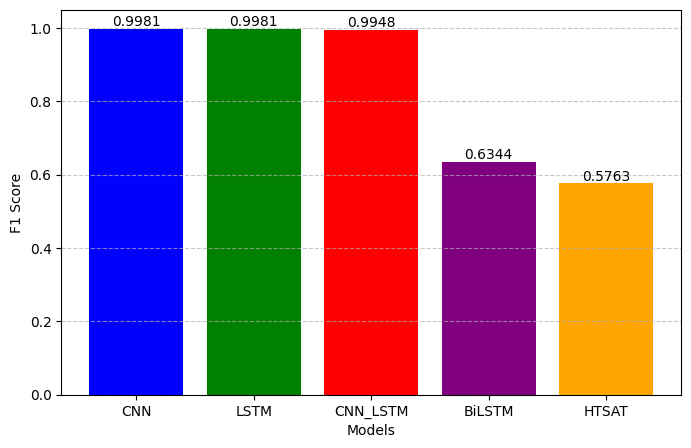

In [ ]:
models = [list(entry.keys())[0] for entry in final_results]
f1_scores = [list(entry.values())[0]['f1_score'] for entry in final_results]

# draw bar chart 
plt.figure(figsize=(8, 5))
bars = plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple', 'orange'])

# show value on columns 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)


plt.xlabel("Models")
plt.ylabel("F1 Score")
# plt.title("Comparison of F1 Scores Across Models")
plt.ylim(0, 1.05) # limit 
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# visualize
plt.show()